##                                                                                             ASSIGNMENT 14:  Ethical AI Analysis: Fairness and Explainability.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [13]:
# 1. DATASET PREPARATION
def load_and_prepare_data():
    """
    Load and prepare the Adult Census Income dataset for fairness analysis
    This dataset is commonly used for fairness research
    """
    # For this example, we'll create a synthetic dataset based on Adult Census characteristics
    # In practice, you would load from: sklearn.datasets or download from UCI repository

    print("=" * 50)
    print("1. DATASET PREPARATION")
    print("=" * 50)

    # Create synthetic data similar to Adult Census dataset
    np.random.seed(42)
    n_samples = 5000

    # Generate features
    age = np.random.normal(40, 15, n_samples).astype(int)
    age = np.clip(age, 18, 80)

    # Sensitive attribute: Gender (0: Female, 1: Male)
    gender = np.random.binomial(1, 0.6, n_samples)  # 60% male

    # Education level (0: Low, 1: Medium, 2: High)
    education = np.random.choice([0, 1, 2], n_samples, p=[0.3, 0.5, 0.2])

    # Hours worked per week
    hours_per_week = np.random.normal(40, 10, n_samples)
    hours_per_week = np.clip(hours_per_week, 20, 80)

    # Experience (correlated with age)
    experience = age - 22 + np.random.normal(0, 3, n_samples)
    experience = np.clip(experience, 0, 50)

    # Create bias: males more likely to have high income
    income_prob = (
        0.3 +
        0.2 * (gender == 1) +  # Gender bias
        0.1 * (education / 2) +
        0.05 * (age - 30) / 50 +
        0.1 * (hours_per_week - 40) / 40 +
        0.1 * experience / 50 +
        np.random.normal(0, 0.1, n_samples)
    )

    income = (income_prob > 0.5).astype(int)

    # Create DataFrame
    data = pd.DataFrame({
        'age': age,
        'gender': gender,
        'education': education,
        'hours_per_week': hours_per_week,
        'experience': experience,
        'income': income
    })

    # Map categorical variables for interpretability
    data['gender_str'] = data['gender'].map({0: 'Female', 1: 'Male'})
    data['education_str'] = data['education'].map({0: 'Low', 1: 'Medium', 2: 'High'})
    data['income_str'] = data['income'].map({0: '<=50K', 1: '>50K'})

    print(f"Dataset shape: {data.shape}")
    print(f"\nDataset info:")
    print(data.describe())

    print(f"\nTarget distribution:")
    print(data['income_str'].value_counts())

    print(f"\nGender distribution:")
    print(data['gender_str'].value_counts())

    # Check for bias in data
    print(f"\nIncome by Gender:")
    print(pd.crosstab(data['gender_str'], data['income_str'], normalize='index'))

    return data

def preprocess_data(data):
    """
    Preprocess the dataset for model training
    """
    print("\nPreprocessing data...")

    # Select features and target
    feature_cols = ['age', 'education', 'hours_per_week', 'experience']
    X = data[feature_cols].copy()
    y = data['income'].copy()
    sensitive_feature = data['gender'].copy()

    print(f"Features selected: {feature_cols}")
    print(f"Target variable: income (0: <=50K, 1: >50K)")
    print(f"Sensitive attribute: gender (0: Female, 1: Male)")

    return X, y, sensitive_feature

In [14]:
# 2. MODEL TRAINING AND EVALUATION

def train_and_evaluate_model(X, y, sensitive_feature):
    """
    Train logistic regression model and evaluate performance
    """
    print("\n" + "=" * 50)
    print("2. MODEL TRAINING AND EVALUATION")
    print("=" * 50)

    # Split data
    X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
        X, y, sensitive_feature, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'max_iter': [1000]
    }

    print("Performing hyperparameter tuning...")
    lr = LogisticRegression(random_state=42)
    grid_search = GridSearchCV(
        lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1
    )

    grid_search.fit(X_train_scaled, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")

    # Train final model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred_train = best_model.predict(X_train_scaled)
    y_pred_test = best_model.predict(X_test_scaled)
    y_pred_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate performance
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"\nModel Performance:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    print(f"\nConfusion Matrix:")
    print(cm)

    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred_test,
                              target_names=['<=50K', '>50K']))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['<=50K', '>50K'],
                yticklabels=['<=50K', '>50K'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return {
        'model': best_model,
        'scaler': scaler,
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        's_train': s_train, 's_test': s_test,
        'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled,
        'y_pred_test': y_pred_test,
        'y_pred_proba_test': y_pred_proba_test
    }

In [15]:
# 3. FAIRNESS ANALYSIS

def fairness_analysis(model_results):
    """
    Perform comprehensive fairness analysis using Fairlearn
    """
    print("\n" + "=" * 50)
    print("3. FAIRNESS ANALYSIS")
    print("=" * 50)

    model = model_results['model']
    y_test = model_results['y_test']
    y_pred_test = model_results['y_pred_test']
    s_test = model_results['s_test']

    # Create MetricFrame for fairness analysis
    print("Computing fairness metrics...")

    # Define metrics to compute
    metrics = {
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'false_positive_rate': false_positive_rate,
        'true_positive_rate': true_positive_rate
    }

    # Create MetricFrame
    mf = MetricFrame(
        metrics=metrics,
        y_true=y_test,
        y_pred=y_pred_test,
        sensitive_features=s_test
    )

    print("Fairness Metrics by Gender:")
    print("=" * 40)
    print(mf.by_group)

    # Overall metrics
    print(f"\nOverall Metrics:")
    print("=" * 20)
    print(mf.overall)

    # Compute fairness differences
    dp_diff = demographic_parity_difference(
        y_test, y_pred_test, sensitive_features=s_test
    )

    eo_diff = equalized_odds_difference(
        y_test, y_pred_test, sensitive_features=s_test
    )

    print(f"\nFairness Constraints:")
    print("=" * 25)
    print(f"Demographic Parity Difference: {dp_diff:.4f}")
    print(f"Equalized Odds Difference: {eo_diff:.4f}")

    # Interpretation
    print(f"\nInterpretation:")
    print("=" * 15)
    if abs(dp_diff) > 0.1:
        print("⚠️  HIGH BIAS: Significant demographic parity violation")
    elif abs(dp_diff) > 0.05:
        print("⚠️  MODERATE BIAS: Some demographic parity concerns")
    else:
        print("✅ LOW BIAS: Acceptable demographic parity")

    if abs(eo_diff) > 0.1:
        print("⚠️  HIGH BIAS: Significant equalized odds violation")
    elif abs(eo_diff) > 0.05:
        print("⚠️  MODERATE BIAS: Some equalized odds concerns")
    else:
        print("✅ LOW BIAS: Acceptable equalized odds")

    # Visualize fairness metrics
    visualize_fairness_metrics(mf)

    return mf, dp_diff, eo_diff

def visualize_fairness_metrics(metric_frame):
    """
    Create visualizations for fairness metrics
    """
    print("\nCreating fairness visualizations...")

    # Convert sensitive feature values to readable labels
    df_viz = metric_frame.by_group.copy()
    df_viz.index = df_viz.index.map({0: 'Female', 1: 'Male'})

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Fairness Metrics by Gender', fontsize=16, fontweight='bold')

    metrics = ['accuracy', 'selection_rate', 'false_positive_rate', 'true_positive_rate']
    titles = ['Accuracy', 'Selection Rate', 'False Positive Rate', 'True Positive Rate']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange']

    for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
        ax = axes[i//2, i%2]

        bars = ax.bar(df_viz.index, df_viz[metric], color=color, alpha=0.7, edgecolor='black')
        ax.set_title(title, fontweight='bold')
        ax.set_ylabel('Rate')
        ax.set_ylim(0, 1)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

        # Add horizontal line for overall metric
        overall_val = df_viz[metric].mean()
        ax.axhline(y=overall_val, color='red', linestyle='--', alpha=0.7,
                  label=f'Overall: {overall_val:.3f}')
        ax.legend()

    plt.tight_layout()
    plt.show()



In [16]:
# 4. EXPLAINABILITY ANALYSIS

def explainability_analysis(model_results, X, original_data):
    """
    Apply SHAP and LIME for model explainability
    """
    print("\n" + "=" * 50)
    print("4. EXPLAINABILITY ANALYSIS")
    print("=" * 50)

    model = model_results['model']
    scaler = model_results['scaler']
    X_test = model_results['X_test']
    X_test_scaled = model_results['X_test_scaled']

    # SHAP Analysis
    print("Performing SHAP analysis...")

    # Create SHAP explainer
    explainer = shap.LinearExplainer(model, X_test_scaled)
    shap_values = explainer.shap_values(X_test_scaled)

    # Global explainability - Summary plot
    print("Creating SHAP summary plot...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
    plt.title('SHAP Summary Plot - Global Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns,
                     plot_type="bar", show=False)
    plt.title('SHAP Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Local explainability - Waterfall plot for individual predictions
    print("Creating SHAP waterfall plots for individual predictions...")

    # Select a few interesting cases
    indices_to_explain = [0, 50, 100]  # Different test samples

    for idx in indices_to_explain:
        plt.figure(figsize=(10, 6))

        # Create explanation object
        expected_value = explainer.expected_value
        shap_vals = shap_values[idx]
        features = X_test.iloc[idx]

        # Manual waterfall plot creation (simplified)
        feature_names = X_test.columns.tolist()

        # Sort by absolute SHAP value
        sorted_indices = np.argsort(np.abs(shap_vals))[::-1]

        y_pos = np.arange(len(feature_names))
        colors = ['red' if x < 0 else 'blue' for x in shap_vals[sorted_indices]]

        plt.barh(y_pos, shap_vals[sorted_indices], color=colors, alpha=0.7)
        plt.yticks(y_pos, [feature_names[i] for i in sorted_indices])
        plt.xlabel('SHAP Value')
        plt.title(f'SHAP Values for Test Sample {idx}\n'
                 f'Prediction: {model.predict(X_test_scaled[idx:idx+1])[0]} '
                 f'(Prob: {model.predict_proba(X_test_scaled[idx:idx+1])[0][1]:.3f})')

        # Add feature values as text
        for i, (feat_idx, shap_val) in enumerate(zip(sorted_indices, shap_vals[sorted_indices])):
            feat_val = features.iloc[feat_idx]
            plt.text(shap_val + 0.001 if shap_val >= 0 else shap_val - 0.001, i,
                    f' = {feat_val:.2f}', va='center',
                    ha='left' if shap_val >= 0 else 'right')

        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()

    # LIME Analysis
    print("Performing LIME analysis...")

    # Create LIME explainer
    lime_explainer = LimeTabularExplainer(
        X_test_scaled,
        feature_names=X_test.columns,
        class_names=['<=50K', '>50K'],
        mode='classification'
    )

    # Explain a few predictions with LIME
    for idx in [0, 50]:
        print(f"\nLIME Explanation for Test Sample {idx}:")
        print("=" * 45)

        # Generate explanation
        exp = lime_explainer.explain_instance(
            X_test_scaled[idx],
            model.predict_proba,
            num_features=len(X_test.columns)
        )

        # Show explanation
        print("Top features influencing prediction:")
        for feature, importance in exp.as_list():
            print(f"  {feature}: {importance:.4f}")

        # Plot LIME explanation
        fig = exp.as_pyplot_figure()
        fig.suptitle(f'LIME Explanation - Test Sample {idx}', fontweight='bold')
        plt.tight_layout()
        plt.show()

    return shap_values, explainer

In [17]:
# 5. MAIN EXECUTION FUNCTION

def main():
    """
    Main function to run the complete ethical AI analysis
    """
    print("ETHICAL AI ANALYSIS: Fairness and Explainability in Machine Learning")
    print("=" * 80)

    # 1. Dataset preparation
    data = load_and_prepare_data()
    X, y, sensitive_feature = preprocess_data(data)

    # 2. Model training and evaluation
    model_results = train_and_evaluate_model(X, y, sensitive_feature)

    # 3. Fairness analysis
    metric_frame, dp_diff, eo_diff = fairness_analysis(model_results)

    # 4. Explainability analysis
    shap_values, shap_explainer = explainability_analysis(model_results, X, data)

    # 5. Summary and recommendations
    print("\n" + "=" * 50)
    print("5. SUMMARY AND RECOMMENDATIONS")
    print("=" * 50)

    print("Key Findings:")
    print("=" * 15)
    print(f"• Model Accuracy: {accuracy_score(model_results['y_test'], model_results['y_pred_test']):.4f}")
    print(f"• Demographic Parity Difference: {dp_diff:.4f}")
    print(f"• Equalized Odds Difference: {eo_diff:.4f}")

    print(f"\nRecommendations:")
    print("=" * 15)

    if abs(dp_diff) > 0.05 or abs(eo_diff) > 0.05:
        print("• ⚠️  BIAS DETECTED: Consider bias mitigation techniques")
        print("• Apply fairness constraints during training")
        print("• Use preprocessing techniques to reduce bias")
        print("• Consider post-processing methods to improve fairness")
    else:
        print("• ✅ Model shows acceptable fairness levels")
        print("• Continue monitoring for bias in production")

    print("• Regularly audit model performance across different groups")
    print("• Implement explainability tools in production")
    print("• Establish fairness metrics monitoring")
    print("• Consider stakeholder feedback in model evaluation")

    print(f"\nEthical Considerations:")
    print("=" * 25)
    print("• Transparency: Model decisions should be explainable")
    print("• Accountability: Clear responsibility for model outcomes")
    print("• Fairness: Equal treatment across demographic groups")
    print("• Privacy: Protect sensitive individual information")
    print("• Beneficence: Ensure model benefits society")

    return {
        'data': data,
        'model_results': model_results,
        'fairness_metrics': metric_frame,
        'shap_values': shap_values
    }

ETHICAL AI ANALYSIS: Fairness and Explainability in Machine Learning
1. DATASET PREPARATION
Dataset shape: (5000, 9)

Dataset info:
               age       gender    education  hours_per_week   experience  \
count  5000.000000  5000.000000  5000.000000     5000.000000  5000.000000   
mean     40.077000     0.615400     0.899800       40.368367    18.437170   
std      13.897629     0.486549     0.708986        9.895697    13.372032   
min      18.000000     0.000000     0.000000       20.000000     0.000000   
25%      30.000000     0.000000     0.000000       33.384616     7.131118   
50%      40.000000     1.000000     1.000000       40.326312    17.840844   
75%      49.000000     1.000000     1.000000       47.165046    27.828215   
max      80.000000     1.000000     2.000000       80.000000    50.000000   

            income  
count  5000.000000  
mean      0.556600  
std       0.496836  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max   

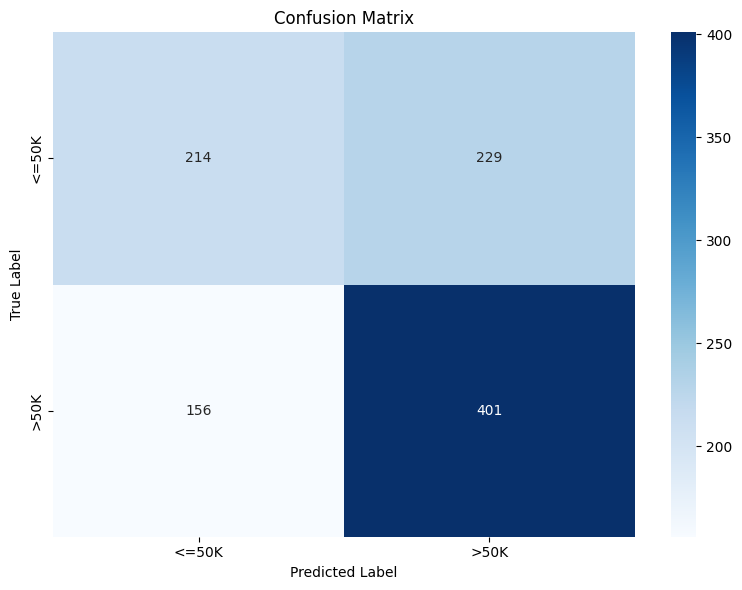


3. FAIRNESS ANALYSIS
Computing fairness metrics...
Fairness Metrics by Gender:
        accuracy  selection_rate  false_positive_rate  true_positive_rate
gender                                                                   
0       0.503836        0.636829             0.582803            0.857143
1       0.686371        0.625616             0.356589            0.697917

Overall Metrics:
accuracy               0.615000
selection_rate         0.630000
false_positive_rate    0.516930
true_positive_rate     0.719928
dtype: float64

Fairness Constraints:
Demographic Parity Difference: 0.0112
Equalized Odds Difference: 0.2262

Interpretation:
✅ LOW BIAS: Acceptable demographic parity
⚠️  HIGH BIAS: Significant equalized odds violation

Creating fairness visualizations...


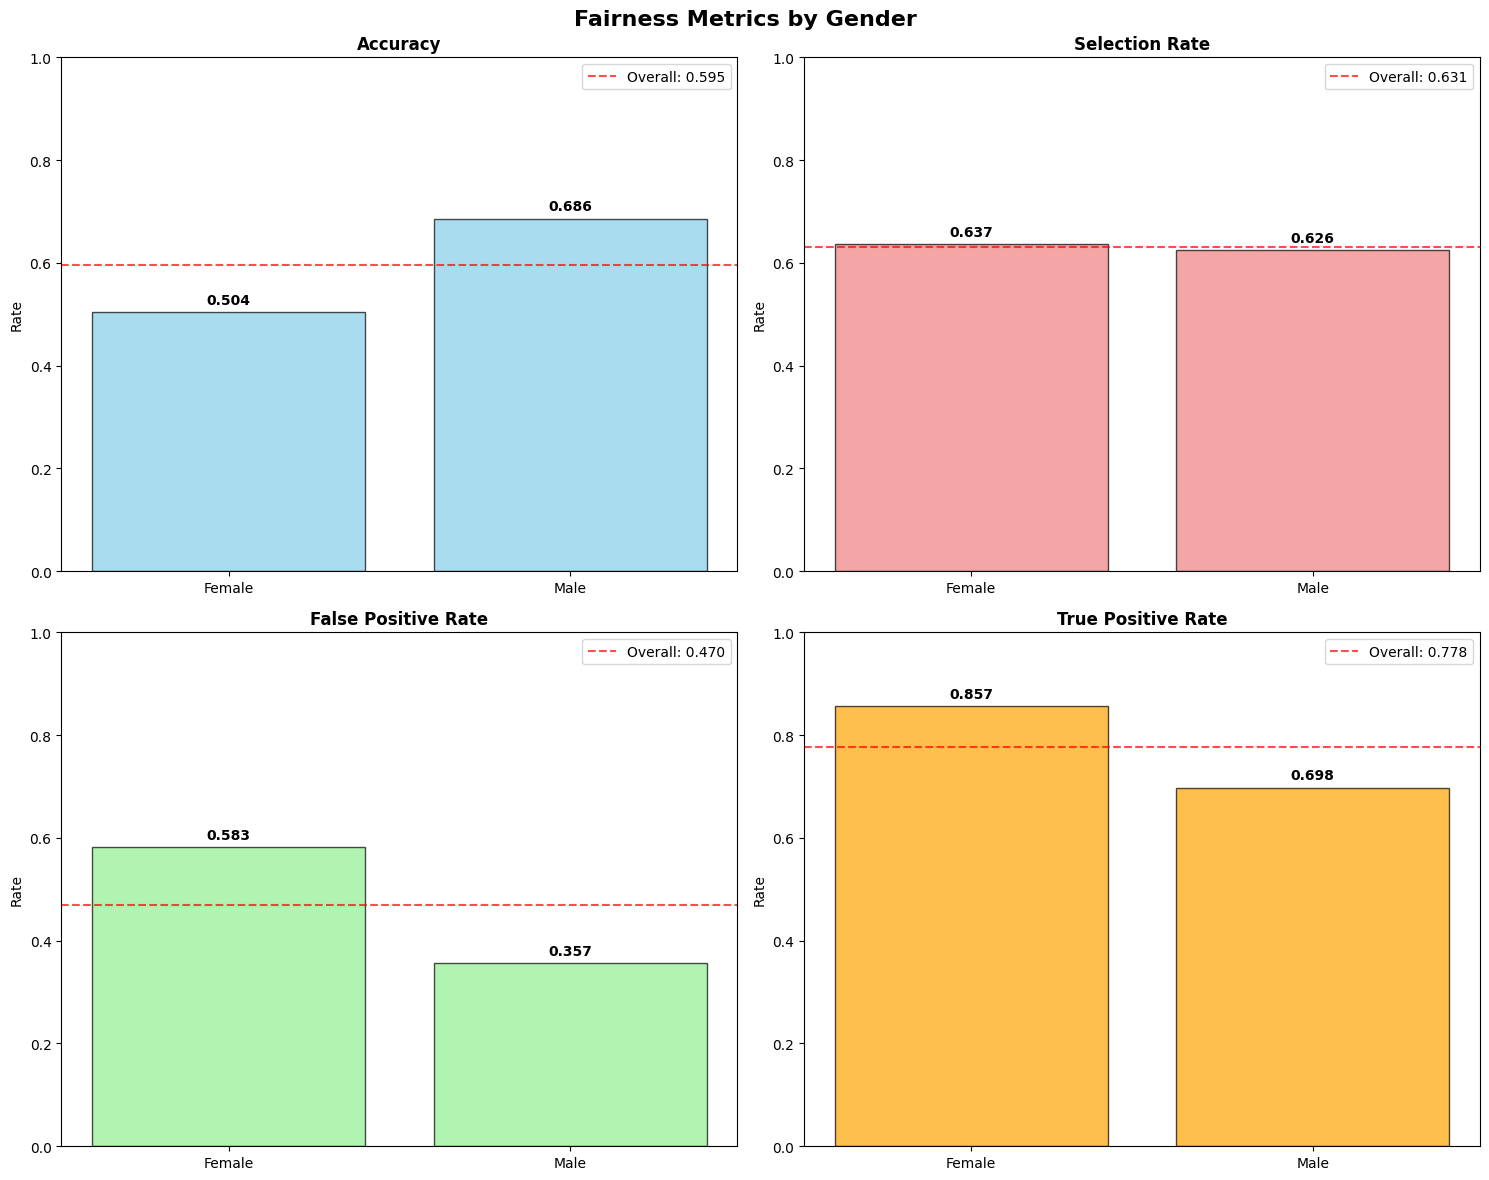


4. EXPLAINABILITY ANALYSIS
Performing SHAP analysis...
Creating SHAP summary plot...


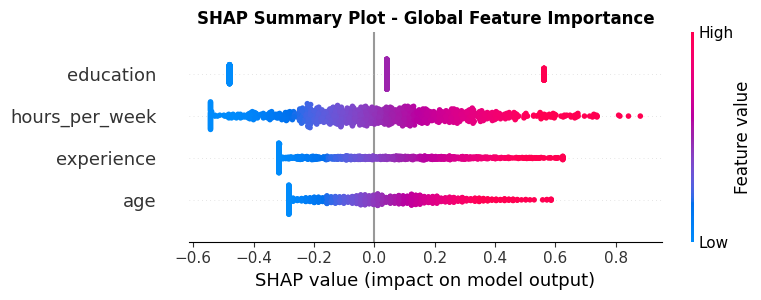

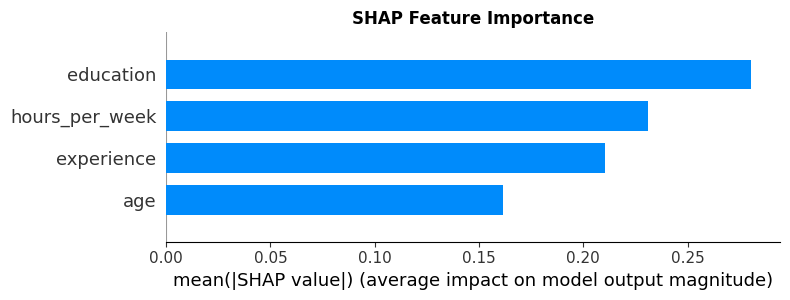

Creating SHAP waterfall plots for individual predictions...


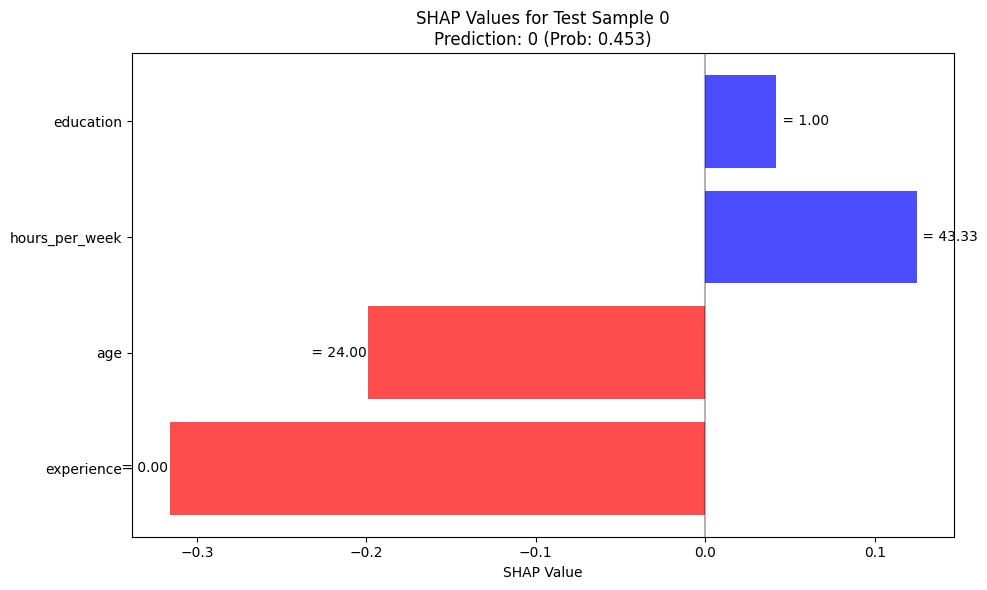

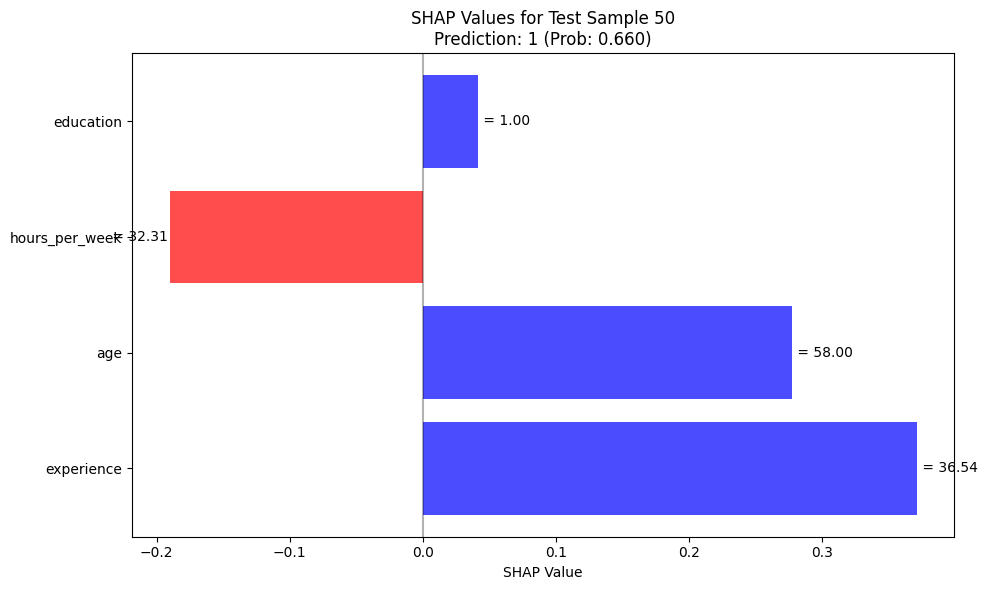

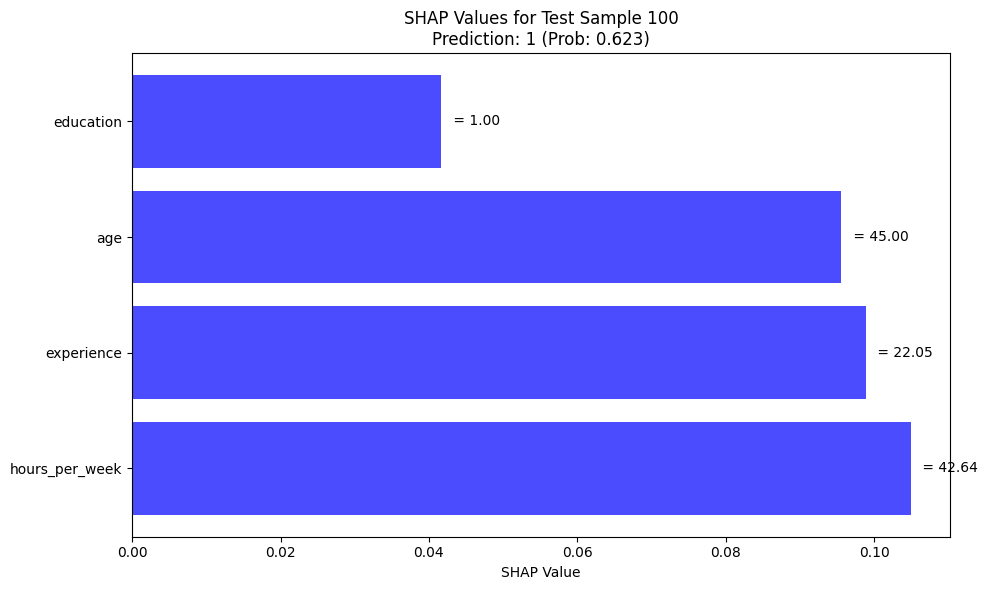

Performing LIME analysis...

LIME Explanation for Test Sample 0:
Top features influencing prediction:
  experience <= -0.80: -0.0922
  age <= -0.72: -0.0765
  -1.27 < education <= 0.13: -0.0402
  -0.09 < hours_per_week <= 0.64: 0.0229


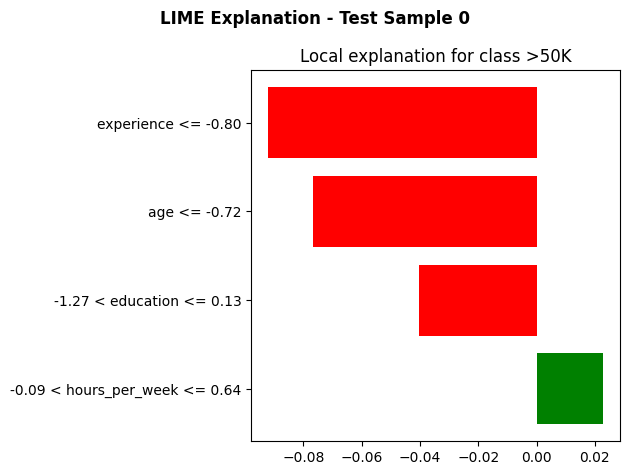


LIME Explanation for Test Sample 50:
Top features influencing prediction:
  hours_per_week <= -0.76: -0.1155
  experience > 0.75: 0.1015
  age > 0.72: 0.0849
  -1.27 < education <= 0.13: -0.0349


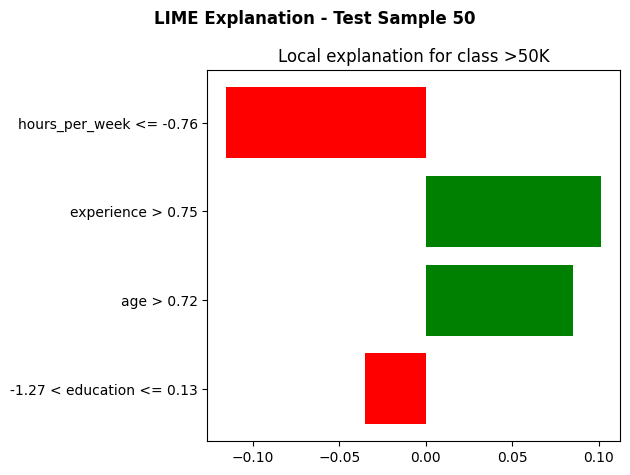


5. SUMMARY AND RECOMMENDATIONS
Key Findings:
• Model Accuracy: 0.6150
• Demographic Parity Difference: 0.0112
• Equalized Odds Difference: 0.2262

Recommendations:
• ⚠️  BIAS DETECTED: Consider bias mitigation techniques
• Apply fairness constraints during training
• Use preprocessing techniques to reduce bias
• Consider post-processing methods to improve fairness
• Regularly audit model performance across different groups
• Implement explainability tools in production
• Establish fairness metrics monitoring
• Consider stakeholder feedback in model evaluation

Ethical Considerations:
• Transparency: Model decisions should be explainable
• Accountability: Clear responsibility for model outcomes
• Fairness: Equal treatment across demographic groups
• Privacy: Protect sensitive individual information
• Beneficence: Ensure model benefits society

🎉 Analysis completed successfully!
All visualizations and metrics have been generated.


In [18]:
if __name__ == "__main__":
    # Note: Make sure to install required packages first:
    # pip install fairlearn shap lime

    try:
        results = main()
        print("\n🎉 Analysis completed successfully!")
        print("All visualizations and metrics have been generated.")
    except Exception as e:
        print(f"\n❌ Error occurred: {e}")
        print("Please ensure all required packages are installed:")
        print("pip install fairlearn shap lime matplotlib seaborn scikit-learn pandas numpy")